In [ ]:
# 1. Install required packages (if not already installed)
# pip install spatialdata spatialdata-io

# 2. Import Xenium reader and pandas
from spatialdata_io.readers.xenium import xenium
import pandas as pd

# 3. Specify Xenium output directory
data_dir = (
    "/mnt/taobo.hu/long/10X_datasets/Xenium/"
    "Xenium_5K/Xenium_Prime_Human_Lung_Cancer_FFPE_outs"
)

# 4. Load the entire dataset with xenium()
#    This will automatically load `cell_feature_matrix.h5`, `transcripts.parquet`, `cells.parquet`, etc.
sdata = xenium(
    path=data_dir,
    cells_boundaries=False,  # Set to True if you want to load cell boundary data
    n_jobs=64                # Number of parallel threads, adjust based on your machine
)

# 5. List all available AnnData matrices
print("Available tables:", list(sdata.tables.keys()))
# Usually there will be a key called "table", corresponding to the cell × gene counts matrix

# 6. Extract the original gene × cell matrix
adata = sdata.tables["table"]

/home/taobo.hu/miniconda3/envs/py311/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/home/taobo.hu/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


INFO     reading                                                                                                   
         /mnt/taobo.hu/long/10X_datasets/Xenium/Xenium_5K/Xenium_Prime_Human_Lung_Cancer_FFPE_outs/cell_feature_mat
         rix.h5                                                                                                    


/tmp/ipykernel_475887/2404535453.py:16: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = xenium(


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
Available tables: ['table']


In [ ]:
from sfplot import load_xenium_data

adata = load_xenium_data(data_dir, normalize=False)

INFO     reading                                                                                                   
         /mnt/taobo.hu/long/10X_datasets/Xenium/Xenium_5K/Xenium_Prime_Human_Lung_Cancer_FFPE_outs/cell_feature_mat
         rix.h5                                                                                                    


/home/taobo.hu/miniconda3/envs/py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/home/taobo.hu/miniconda3/envs/py311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


检测到已存在 analysis 目录和相关 csv 文件，直接读取...


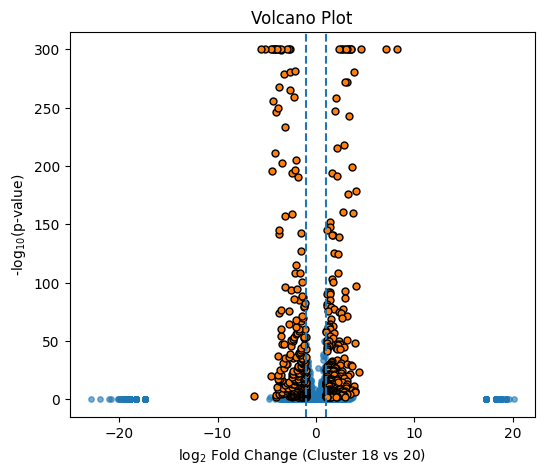

2025-06-23 14:13:39,363 INFO     fontTools.subset | maxp pruned
2025-06-23 14:13:39,371 INFO     fontTools.subset | cmap pruned
2025-06-23 14:13:39,372 INFO     fontTools.subset | kern dropped
2025-06-23 14:13:39,372 INFO     fontTools.subset | post pruned
2025-06-23 14:13:39,373 INFO     fontTools.subset | FFTM dropped
2025-06-23 14:13:39,376 INFO     fontTools.subset | GPOS pruned
2025-06-23 14:13:39,379 INFO     fontTools.subset | GSUB pruned
2025-06-23 14:13:39,384 INFO     fontTools.subset | glyf pruned
2025-06-23 14:13:39,385 INFO     fontTools.subset | Added gid0 to subset
2025-06-23 14:13:39,385 INFO     fontTools.subset | Added first four glyphs to subset
2025-06-23 14:13:39,386 INFO     fontTools.subset | Closing glyph list over 'MATH': 38 glyphs before
2025-06-23 14:13:39,387 INFO     fontTools.subset | Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'e', 'eight', 'five', 'four', 'l', 'nonmarkin

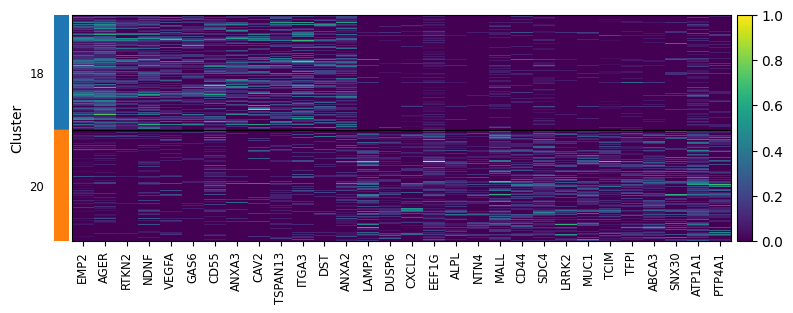

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Assume adata already exists and adata.obs['Cluster'] is string or integer
adata.obs['Cluster'] = adata.obs['Cluster'].astype(str)

# 1. Subset specific clusters (optional, speeds up computation)
clusters = ['18', '20']
adata_sub = adata[adata.obs['Cluster'].isin(clusters)].copy()

# 2. Normalize and log-transform
sc.pp.normalize_total(adata_sub, target_sum=1e4)  # Normalize each cell to total count = 1e4
sc.pp.log1p(adata_sub)                            # Log-transform: log(x + 1)

# 3. Differential expression analysis (without HVG filtering)
sc.tl.rank_genes_groups(
    adata_sub,
    groupby='Cluster',
    groups=['18'],       # Set cluster 18 as the "test group"
    reference='20',      # Use cluster 20 as the reference
    method='wilcoxon',   # Wilcoxon rank-sum test
    n_genes=adata_sub.shape[1]
)

# 4. Extract results into DataFrame
de_df = sc.get.rank_genes_groups_df(adata_sub, group='18')
de_df['-log10(pval)'] = -np.log10(de_df['pvals'] + 1e-300)

# 5. Volcano plot
plt.figure(figsize=(6,5))
plt.scatter(de_df['logfoldchanges'], de_df['-log10(pval)'], s=15, alpha=0.6)
sig = de_df.query('pvals_adj < 0.05 and abs(logfoldchanges) > 1')
plt.scatter(sig['logfoldchanges'], sig['-log10(pval)'], s=25, edgecolor='k')
plt.axvline( 1, linestyle='--')
plt.axvline(-1, linestyle='--')
plt.xlabel('log$_2$ Fold Change (Cluster 18 vs 20)')
plt.ylabel('-log$_{10}$(p-value)')
plt.title('Volcano Plot')
plt.show()

# 6. Heatmap (Top 30 most significant genes)
top30 = de_df.sort_values('pvals_adj')['names'].values[:30]
sc.pl.heatmap(
    adata_sub,
    var_names=top30,
    groupby='Cluster',
    standard_scale='var',
    cmap='viridis',
    show_gene_labels=True,
    figsize=(9,3),
    save='heatmap_top30_cluster18_vs20.pdf'
)
